In [16]:
from maxpy.utils import *
plt.style.use("dark")

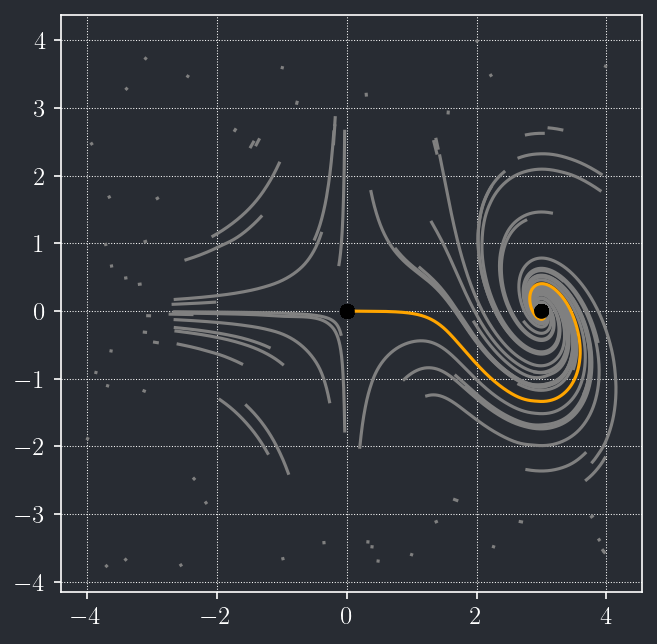

In [82]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
def flow(t, state):
    x, y = state
    return np.array([x, -y])*np.exp(-x**2-y**2) - np.array([(x-3)+y, -2*(x-3)])*np.exp(-(x-3)**2-y**2)
 
def plot_streamline(y0):
    
    t_span = (0.0, 100.0)
    t = np.arange(t_span[0], t_span[1], 0.01)

    result_solve_ivp = solve_ivp(flow, t_span, y0, t_eval=t, method="RK45")

    return result_solve_ivp.y[0, :], result_solve_ivp.y[1, :]

n = 100
plt.figure(figsize=(5,5),dpi=150)

for i in range(n):
    y0 = np.random.uniform(-4,4, size=2) # Initial state of the system
    x, y = plot_streamline(y0)
    plt.plot(x, y, color="gray")
    plt.plot(0,0, "o", color="black")
    plt.plot(3,0, "o", color="black")

y0 = [0.01,0] # Initial state of the system
x, y = plot_streamline(y0)
plt.plot(x, y, color="orange")
plt.plot(0,0, "o", color="black")
plt.plot(3,0, "o", color="black")

In [63]:
np.linalg.eig(np.array([[-1,0],[0,1]]))


(array([-1.,  1.]),
 array([[1., 0.],
        [0., 1.]]))

In [1]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import shutil
import tqdm
import warnings
import numpy as np
import multiprocessing as mp

def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter



def make_gif(fps):
    def decorator(callback):
        def wrapper(data: np.array):#, gifpath=None, fps=25):
            """Wrapper function for imageio to create a gif from any python package
            which is able to save PNG files

            Args:
                callback (callable): Callback function. This function needs exactly two inputs
                data and name. It should use the data to plot whatever needs to be plottet in each time step
                and name should be given to the save function
                data (np.array): List of data which is needed in each frame
                gifpath (str, optional): Path where gif should be saved. Defaults to None.
                fps (int, optional): Frames per second. Defaults to 25.
            """
            gifpath=None 
            print(fps)
            #fps=25
            warnings.filterwarnings("ignore", category=DeprecationWarning)

            # Use unique time-stamp for name is no path is given
            if gifpath is None:
                from datetime import datetime

                eventid = datetime.now().strftime("%Y%m-%d%H-%M%S")
                gifpath = f"./{eventid}.gif"

            # create temp if not already existing
            if not "temp" in os.listdir("./"):
                os.mkdir("temp")

            # Some constants
            nimages = len(data)
            zfill_param = int(np.ceil(np.log10(nimages)))

            # Save images in parallel
            print("Save Images...")
            idxs = np.arange(nimages, dtype=int)
            names = [f"temp/pic{str(i).zfill(zfill_param)}.png" for i in idxs]
            # args = [(data[i], names[i]) for i in range(nimages)]
            # with mp.Pool() as p:
            #     p.starmap(callback, tqdm.tqdm(args, total=nimages))
            for i in range(nimages):
                callback(data[i], names[i])
            print("Done.")

            # Use imageio to create gif from images
            images = []
            print("Make Gif...")
            for filename in tqdm.tqdm(sorted(glob.glob("temp/pic*"))):
                images.append(imageio.imread(filename))
            imageio.mimsave(gifpath, images, format="GIF", duration=(1000 / fps), loop=0)

            # Remove temporary folder
            shutil.rmtree("./temp")
            print("Done.")

            if is_notebook():
                from IPython.display import Image
                display(Image(data=open(gifpath,'rb').read(), format='png'))
        return wrapper
    return decorator


In [2]:

@make_gif(fps=25)
def cback(data, name):#, gifpath="./", fps=100):
    plt.imshow(
        data,
        cmap="turbo",
        aspect="auto",
        origin="lower",
        extent=[0, 1, 0, 1],
    )
    plt.savefig(name)
    return 0

25
Save Images...
Done.
Make Gif...


100%|██████████| 100/100 [00:00<00:00, 450.04it/s]


Done.


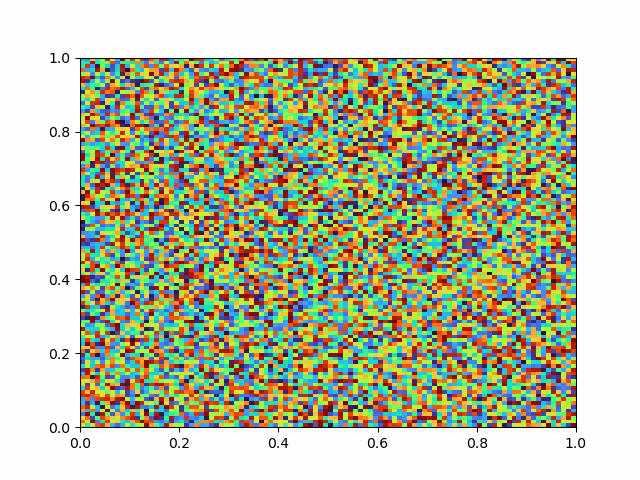

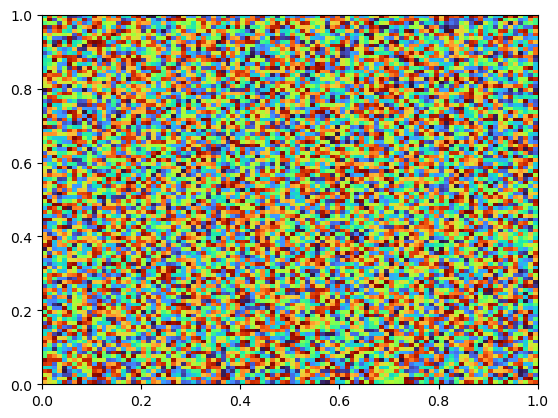

In [3]:
data = np.random.random((100,100,100))
cback(data)

In [12]:
import jax.numpy as jnp
from jax import jit

@jit
def get_jacobian(vec, dx, dy, dz):
    dudx, dudy, dudz = jnp.gradient(vec[0])
    dvdx, dvdy, dvdz = jnp.gradient(vec[1])
    dwdx, dwdy, dwdz = jnp.gradient(vec[2])

    return jnp.array([[dudx, dudy, dudz], [dvdx, dvdy, dvdz], [dwdx, dwdy, dwdz]])

@jit
def get_directional_derivative(vec, x, y, z):
    Jac = get_jacobian(vec, x, y, z)

    # Reshape vec for vectorized operations
    vec_reshaped = vec.reshape(vec.shape[0], -1).T
    Jac_reshaped = Jac.reshape(Jac.shape[0], Jac.shape[1], -1).transpose(2, 0, 1)

    # Calculate directional derivative (grad u)u
    Jv = (Jac_reshaped @ vec_reshaped[..., jnp.newaxis]).squeeze(-1)

    return Jv

In [11]:
%timeit Jv = get_directional_derivative(z, lin, lin, lin)

1.97 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit Jv = get_directional_derivative(z, lin, lin, lin)

927 ms ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit Jv = get_directional_derivative(z, lin, lin, lin)

30.8 ms ± 5.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
# remove bad prefix
from os import rename, listdir

badprefix = "2023-10-14"
path = "/run/media/max/Data/Simulations/Simulation/hybrid_3d_turbulence/vtk/"
fnames = listdir("/run/media/max/Data/Simulations/Simulation/hybrid_3d_turbulence/vtk")
#print(fnames)
for fname in fnames:
    if fname.startswith(badprefix):
        print(fname)
        rename(path + fname, path + fname.replace(badprefix, "2023-10-13"))

2023-10-14-B_hybrid_kinetic_97.vti
2023-10-14-B_hybrid_kinetic_98.vti
2023-10-14-B_hybrid_kinetic_87.vti
2023-10-14-B_hybrid_kinetic_107.vti
2023-10-14-B_hybrid_kinetic_106.vti
2023-10-14-B_hybrid_kinetic_105.vti
2023-10-14-B_hybrid_kinetic_101.vti
2023-10-14-B_hybrid_kinetic_93.vti
2023-10-14-B_hybrid_kinetic_100.vti
2023-10-14-B_hybrid_kinetic_80.vti
2023-10-14-B_hybrid_kinetic_90.vti
2023-10-14-B_hybrid_kinetic_91.vti
2023-10-14-B_hybrid_kinetic_104.vti
2023-10-14-B_hybrid_kinetic_95.vti
2023-10-14-B_hybrid_kinetic_89.vti
2023-10-14-B_hybrid_kinetic_82.vti
2023-10-14-B_hybrid_kinetic_86.vti
2023-10-14-B_hybrid_kinetic_103.vti
2023-10-14-B_hybrid_kinetic_83.vti
2023-10-14-B_hybrid_kinetic_84.vti
2023-10-14-B_hybrid_kinetic_79.vti
2023-10-14-B_hybrid_kinetic_88.vti
2023-10-14-B_hybrid_kinetic_85.vti
2023-10-14-B_hybrid_kinetic_94.vti
2023-10-14-B_hybrid_kinetic_96.vti
2023-10-14-B_hybrid_kinetic_102.vti
2023-10-14-B_hybrid_kinetic_78.vti
2023-10-14-B_hybrid_kinetic_99.vti
2023-10-14-B

In [16]:
import tqdm
import imageio
import glob

print("Make Gif...")
images = []
gifpath = "/home/max/Nextcloud/Bachelor/Pictures/gifs/hybrid-kinetic.gif"
fps = 15

for filename in tqdm.tqdm(sorted(glob.glob("/home/max/Pictures/testanim*.jpeg"))):
    images.append(imageio.imread(filename))
imageio.mimsave(gifpath, images, format="GIF", duration=(1000 / fps), loop=0)

Make Gif...


  0%|          | 0/104 [00:00<?, ?it/s]/tmp/ipykernel_123287/3807559288.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
100%|██████████| 104/104 [00:00<00:00, 227.12it/s]


In [11]:
import pandas as pd
import numpy as np
data = pd.read_csv("~/Temp/test.csv")
print(data.keys())

Index(['Acceleration:0', 'Acceleration:1', 'Acceleration:2', 'Jac:0', 'Jac:1',
       'Jac:2', 'Jacobian:0', 'Jacobian:1', 'Jacobian:2', 'Jacobian:3',
       'Jacobian:4', 'Jacobian:5', 'Jacobian:6', 'Jacobian:7', 'Jacobian:8',
       'RealEigenvalueMajor', 'RealEigenvalueMedium', 'RealEigenvalueMinor',
       'RealEigenvectorMajor:0', 'RealEigenvectorMajor:1',
       'RealEigenvectorMajor:2', 'RealEigenvectorMedium:0',
       'RealEigenvectorMedium:1', 'RealEigenvectorMedium:2',
       'RealEigenvectorMinor:0', 'RealEigenvectorMinor:1',
       'RealEigenvectorMinor:2', 'vectors:0', 'vectors:1', 'vectors:2',
       'vtkValidPointMask', 'Points:0', 'Points:1', 'Points:2'],
      dtype='object')


In [26]:
def get_vtk_jac(idx):
    jac = np.array([data[f"Jacobian:{i}"].to_numpy()[idx] for i in range(9)]) 
    return jac.reshape(3,3, order="F")

def get_vectors(idx):
    vec = np.array([data[f"vectors:{i}"].to_numpy()[idx] for i in range(3)]) 
    return vec

def get_accel(idx):
    vec = np.array([data[f"Acceleration:{i}"].to_numpy()[idx] for i in range(3)]) 
    return vec

index = 0

vec =get_vectors(index)
jac = get_vtk_jac(index)
acc = get_accel(index)

In [32]:
index = 0

for index in range(100):
    vec =get_vectors(index)
    jac = get_vtk_jac(index)
    acc = get_accel(index)
    eigvals, eigvecs = np.linalg.eig(jac)
    print(index)
    print(acc, jac@vec)
    print(vec)
    print(eigvals.sum())
    print(np.arccos(vec@acc/(np.linalg.norm(vec)*np.linalg.norm(acc)))/(2*np.pi)*360)

0
[-0.00012996 -0.00012586 -0.00114159] [-0.00012983 -0.00012588 -0.00114166]
[0.20732985 0.2007833  1.82121168]
-0.025224593333654215
179.99995202126337
1
[-0.00012994 -0.00012584 -0.00114147] [-0.00012979 -0.00012585 -0.00114155]
[0.20732772 0.20078019 1.82121213]
-0.02522347723094341
179.99992549143263
2
[ 0.00057255 -0.00023224 -0.00373025] [ 0.00063018 -0.00025652 -0.00372667]
[-0.29764837  0.12073453  1.93923958]
0.010004851653730992
179.99997744356526
3
[ 0.00071185 -0.00032676 -0.00527651] [ 0.00075244 -0.00034324 -0.00527513]
[-0.26256624  0.12052327  1.94623336]
0.011251383208589455
179.99998108163973
4
[ 0.00070664 -0.00036645 -0.00587982] [ 0.00073845 -0.00038153 -0.00590344]
[-0.23491085  0.12182025  1.95465536]
0.01220165644451389
179.99997757320102
5
[4.20259617e-05 1.21384064e-05 6.99038016e-04] [3.75519483e-05 9.95148473e-06 7.08723807e-04]
[0.11057729 0.03193487 1.83928407]
-0.017765013751487535
0.00010176394518863295
6
[ 4.09935360e-05 -2.50519578e-06  1.06823717e-03

In [30]:
print(np.linalg.eig(jac))

(array([-0.03114512,  0.00654735, -0.00062683]), array([[ 0.05081959, -0.90516499,  0.11242843],
       [-0.9692367 , -0.05483923,  0.10888672],
       [-0.2408269 ,  0.42150801,  0.98767582]]))


# Sobel Derivative

In [78]:
import numpy as np
from scipy import ndimage


def get_gradient(scalar, linx, liny, linz):
    dx = ndimage.sobel(scalar, 0)  # x derivative
    dy = ndimage.sobel(scalar, 1)  # y derivative
    dz = ndimage.sobel(scalar, 2)  # z derivative
    print(dx.shape)
    return dx, dy, dz


def get_jacobian_sobel(vec, linx, liny, linz):
    dudx, dudy, dudz = get_gradient(vec[0], linx, liny, linz)
    dvdx, dvdy, dvdz = get_gradient(vec[1], linx, liny, linz)
    dwdx, dwdy, dwdz = get_gradient(vec[2], linx, liny, linz)
    return np.array([[dudx, dudy, dudz], [dvdx, dvdy, dvdz], [dwdx, dwdy, dwdz]])#.transpose(1,0,2,3,4)

lin = np.linspace(-1,1,32)
x,y,z = np.meshgrid(lin,lin,lin)

vec = np.array([x**2,y**2,z**2])
Jac_anal = np.array([[2*x,np.zeros(x.shape),np.zeros(x.shape)], [np.zeros(x.shape),2*y,np.zeros(x.shape)], [np.zeros(x.shape),np.zeros(x.shape),2*z]])

Jac = get_jacobian_sobel(vec, lin, lin, lin)
print(np.sqrt(np.sum((Jac-Jac_anal)**2)))


(32, 32, 32)
(32, 32, 32)
(32, 32, 32)
692.4051752758808


In [83]:
z = x**2+y**2+z**2
grad = np.array([2*x, 2*y, 2*z])

dx,dy,dz = get_gradient(z, lin, lin, lin)
grad_sobel = np.array([dx, dy, dz])

dx,dy,dz = np.gradient(z, lin, lin, lin)
grad_numpy = np.array([dx, dy, dz])

print(np.sqrt(np.mean((grad/grad_sobel))))

(32, 32, 32)
1.706401369716956e-08


In [84]:
from findiff import FinDiff

dx = lin[1] - lin[0]
dy = lin[1] - lin[0]
dz = lin[1] - lin[0]

d_dx = FinDiff(0,dx, 1, acc=4)
d_dy = FinDiff(1,dy, 1, acc=4)
d_dz = FinDiff(2,dz, 1, acc=4)

dudx = d_dx(z)
dudy = d_dy(z)
dudz = d_dz(z)

gradient = np.array([dudx, dudy, dudy])

In [85]:
print(np.sqrt(np.sum((gradient-grad)**2)))

1771.3215357822685


In [10]:
from findiff import Gradient, Divergence, Laplacian, Curl
import matplotlib.pyplot as plt
import numpy as np
lin = np.linspace(-1,1,32)
x,y,z = np.meshgrid(lin,lin,lin, indexing="ij")

z = x**2+y**2+z**2

dx = lin[1] - lin[0]
dy = lin[1] - lin[0]
dz = lin[1] - lin[0]

grad = Gradient(h=[dx,dy,dz], acc=2)
grad_anal = np.array([2*x, 2*y, 2*z])
grad_u = grad(z)

print(np.sum(np.abs(grad_anal-grad_u)))

70543.58376690955


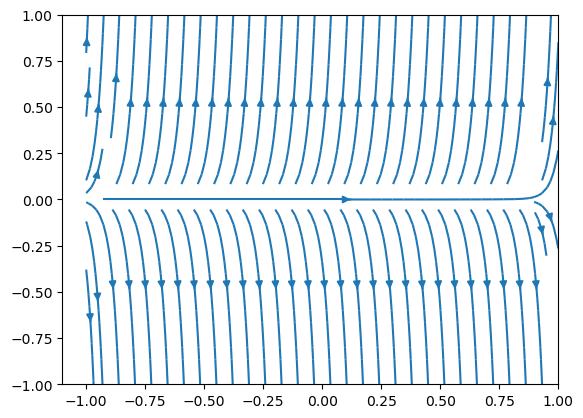

In [29]:
plt.streamplot(x[...,16].T,y[...,16].T, grad_u[2][...,16], grad_u[0][...,16])

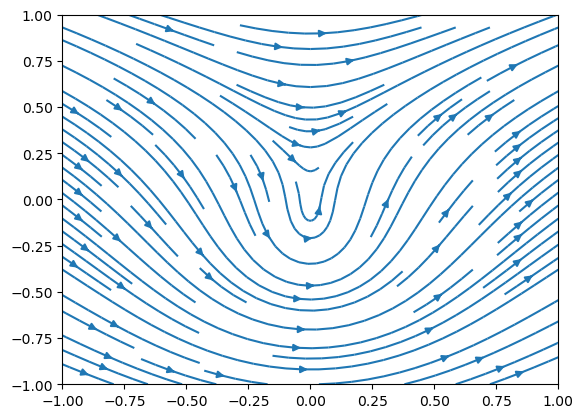

In [30]:
plt.streamplot(x[...,16].T,y[...,16].T, grad_anal[2][...,16], grad_anal[1][...,16])

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from maxpy.utils import save_as_vti

size = 64
lin = np.linspace(-2,2,size)
x,y,z = np.meshgrid(lin,lin,lin, indexing="ij")

u = np.array([y**2-1+z**2,-x,2*z/z])
print(u.shape)
print(u[-1].shape)
spaces = np.linspace(-1,1,size)
u_result = np.zeros_like(u)
for i in range(size):
    liny = np.linspace(spaces[i]-4,spaces[i]+4,size)
    x,y,z = np.meshgrid(lin,liny,lin, indexing="ij")
    u = np.array([y**2-1+z**2,-x,2*z/z])
    u_result[...,i] = u[...,i].copy()

(3, 64, 64, 64)
(64, 64, 64)


In [106]:
save_as_vti(u_result, None, savepath="~/Temp/", name="shifted-bifurcation-line")

/home/max/miniconda3/envs/work/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


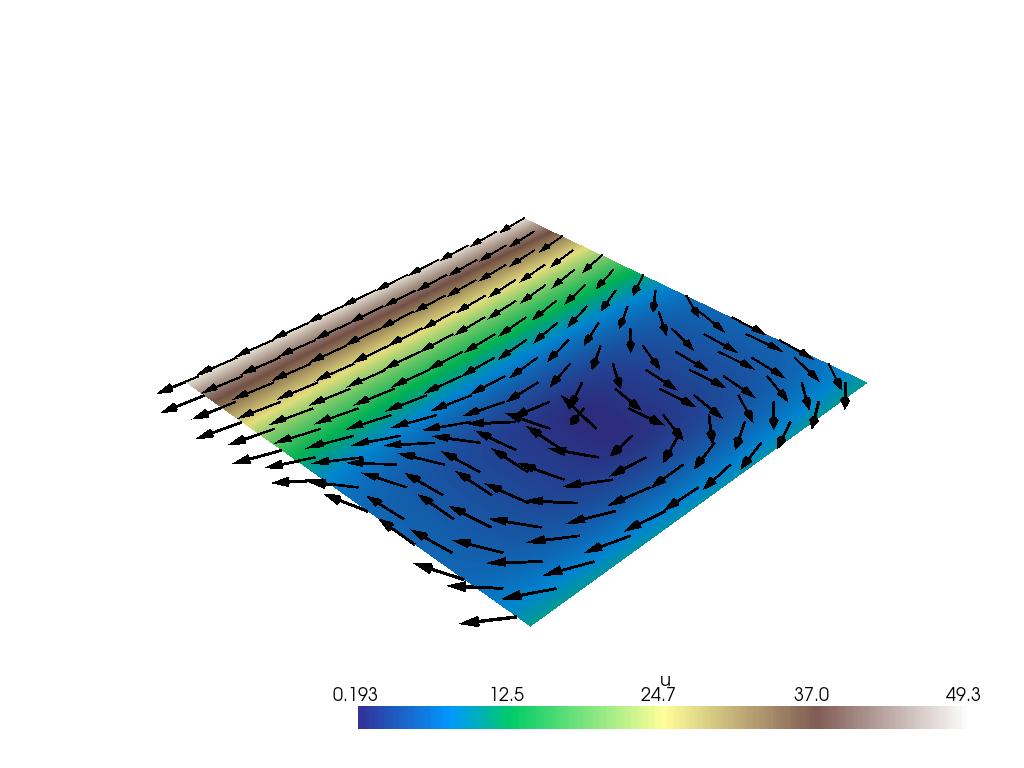

In [7]:
import pyvista as pv
mesh = pv.read("~/Temp/test3.vtp")
arrows = mesh.glyph(scale=1, orient="u", tolerance=0.05)

p = pv.Plotter()
p.add_mesh(arrows, color="black")
p.add_mesh(mesh, scalars="u", cmap="terrain", smooth_shading=True)
p.show()

#cpos = mesh.plot()

In [13]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
plt.style.use('light')
def fun(z):
    return np.array([-z/np.sqrt(1-z**2), 2-np.sqrt(1-z**2), z])

lin = np.linspace(-0.9,0.9,100)

points = fun(lin).T

# Create a poly data object
poly_data = pv.PolyData()

# Add the points to the poly data
poly_data.points = points

# Visualize the poly data
poly_data.save("test.vtk")
